Model: 
\begin{align}
    & x_{ij} \sim \text{Pois}(s_j \lambda_{ij})\\
    & \lambda_{.j} \sim \sum_l \pi_l \hat{\lambda}_{.l}\\
\end{align}
where $\hat{\lambda}_{ij} = x_{ij} / s_j$

NPMLE: 
\begin{align}
    l(\pi_.) &= \sum_{j = 1}^p log(\sum_l \pi_l \text{Pois}(x_{.j} | s_j, \hat{\lambda}_{.l})) \\
    & = \sum_{j = 1}^p log(\sum_l \pi_l L_{jl})
\end{align}

Posterior mean:

\begin{align}
    &  w_{jl} := \text{P}(\lambda_{.j} = \hat{\lambda}_{.l} | x_{.j}, \hat{\pi}) \propto \pi_l \text{Pois}(x_{.j} | s_j, \hat{\lambda}_{.l})) = \pi_l L_{jl}\\
    & \lambda_{.j}^{\text{pos mean}} = \sum_l w_{jl} \hat{\lambda}_{.l}
\end{align}

EM algorithm:

* Let $l_{jl} = log p(x_j | s_j, \hat{\lambda}_l)$ and let $l = 1 ... d$ (to be a bit more general). 
* Let $z_j$ denote which prior support $x_j$ is generated from; $q_{jl} := p(z_j = l | x_j, \pi, s_j)$

\begin{align}
    & p(x_j, z_j) = \Pi_{l = 1}^d (p(z_j = l) p(x_j | s_j, \hat{\lambda}_l))^{\delta_{z_j = l}}\\
    & log \ p(x_j, x_j) = \sum_{l = 1}^d \delta_{z_j = l} (log \pi_l + l_{jl})\\
    & E_q log \ p(x_j, x_j) = \sum_{l = 1}^d q_{jl} (log \pi_l + l_{jl})\\
\end{align}

Then we can get iterates:

\begin{align}
    \text{E step:} \ & q_{jl} \propto \pi_l L_{jl}\\
     \text{M step:} \ & \pi_l \propto \sum_j q_{jl} 
\end{align}

In [1]:
%%capture
import os
import sys
import time
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from scipy.stats import poisson
from scipy.special import gammaln
from scipy.special import logsumexp

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 
datadir = "../../../gdrive/github_data/pyJSMF-RAW-data"

from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

np.random.seed(123)


## Implementation

In [2]:
def compute_lamhat(X):
    s = X.sum(axis = 0)
    return X / s, s

# def compute_l0(X, s, lam):
#     _, p = X.shape
#     _, p2 = lam.shape
#     loglik = np.zeros((p, p2))
#     for j in range(p):
#         loglik[j,:] = poisson.logpmf(k = X[:, j][:, None], mu = s[j] * lam).sum(axis = 0)
        
#     return loglik

def compute_l(X, s, lam):
    loglik = X.T @ np.log(lam + 1e-300)
    loglik -= np.outer(s, lam.sum(axis = 0))
    loglik += (np.log(s) * X.sum(axis = 0))[:, None] - gammaln(X + 1).sum(axis = 0)[:,None]
    loglik[loglik < - 600] = -np.inf
    
    return loglik
    
def compute_mll(X,l, pi):
    return logsumexp(l + np.log(pi)[None,:], axis = 1).sum()



def em(X, l, maxiter=20): ## todo: provide an option to initialize with q or pi
    _, d = l.shape
    pi = np.ones(d)/d
    ll = []

    for t in range(maxiter):
        q = np.exp(l + np.log(pi)[None,:])
        q /= q.sum(axis = 1)[:, None]
        q[np.isnan(q)] = 1/d ## nan happens when entire row is 0 ... so set them equally likely

        pi = q.sum(axis = 0)
        pi /= pi.sum()

        ll.append(compute_mll(X, l, pi))
        
    q = np.exp(l + np.log(pi)[None,:])
    q /= q.sum(axis = 1)[:, None]
    q[np.isnan(q)] = 1/d 
        
    return pi, ll, q

def NPMLE(X):
    n, p = X.shape
    lamhat, s = compute_lamhat(X)
    _, d = lamhat.shape
    l = compute_l(X, s, lamhat)
    pi, ll, q = em(X, l)
    lam_pm = lamhat @ q.T
    
    return lam_pm, s, pi, q, ll


## Very small example as sanity check

In [3]:
%%capture
n = 100
p = 120 ## make this larger to increase difficulty
n_top = 20 ## number of top words in each topic
k = 3
doc_len = 80
np.random.seed(123)

X, Atrue, Ftrue, p0, Ltrue = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len, 
                                           n_top = n_top, returnL=True)
w_idx = np.where(X.sum(axis = 0) > 0)[0]
X = X[:,w_idx]

## truth
Pi_true = Ltrue @ Ftrue.T
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar0, k)
Cbar0_pj = pca_proj(Cbar0)

lam_pm, s, pi, q, ll = NPMLE(X)


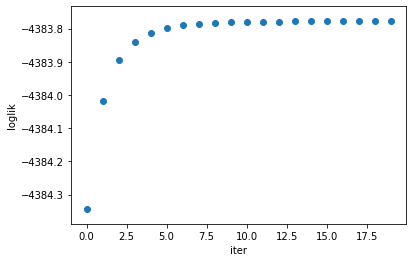

In [4]:
plt.scatter([t for t in range(len(ll))], ll)
plt.xlabel("iter")
plt.ylabel("loglik")
plt.show()

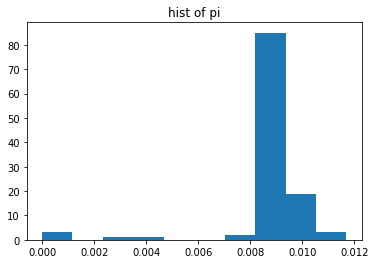

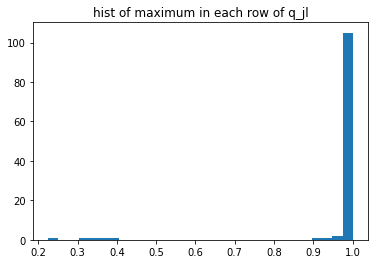

In [5]:
plt.hist(pi)
plt.title("hist of pi")
plt.show()

plt.hist(q.max(axis = 1), bins = 30)
plt.title("hist of maximum in each row of q_jl")
plt.show()

## A harder example

* I think the difficulty comes from high dimensionality: each gene lives in a very high dimensional space; thus it's very unlikely other genes' expression can give a good likelihood. Therefore $\pi_l \approx = 1/p$ for almost all genes, and the posterior weights also almost all lie in itself.


In [6]:
%%capture
n = 1000
p = 1200 ## make this larger to increase difficulty
n_top = 20 ## number of top words in each topic
k = 3
doc_len = 80
np.random.seed(123)

X, Atrue, Ftrue, p0, Ltrue = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len, 
                                           n_top = n_top, returnL=True)
w_idx = np.where(X.sum(axis = 0) > 0)[0]
X = X[:,w_idx]

## truth
Pi_true = Ltrue @ Ftrue.T
Ctrue = Pi_true.T @ Pi_true / n
Cbar0 = Ctrue / Ctrue.sum(axis = 1)[:, None]

S0, _, _ = findS(Cbar0, k)
Cbar0_pj = pca_proj(Cbar0)

lam_pm, s, pi, q, ll = NPMLE(X)


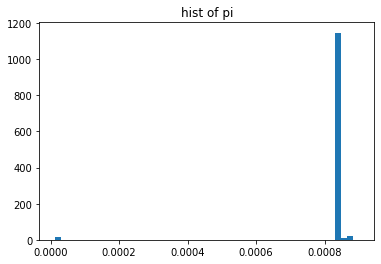

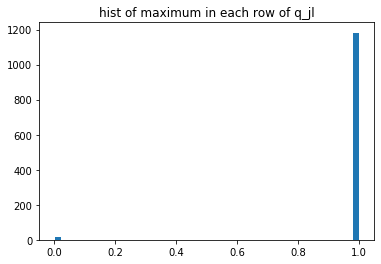

In [7]:
plt.hist(pi, bins = 50)
plt.title("hist of pi")
plt.show()

plt.hist(q.max(axis = 1), bins = 50)
plt.title("hist of maximum in each row of q_jl")
plt.show()

[inference.findS] Start finding the set of anchor bases S...
+ Finish finding set S!
  - Discovered 3 basis vectors by [sparsePartial] method.
  - Elapsed time = 0.0182 seconds



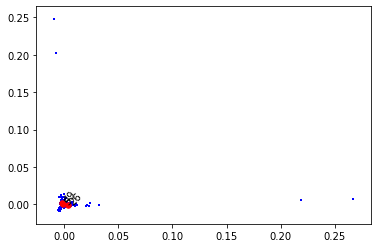

In [8]:
# X_dn = lam_pm * s[None,:]
# Pi = X_dn / X_dn.sum(axis = 0)
# C = (Pi @ Pi.T) / n
# Cbar = C / C.sum(axis = 1)[:, None]
# S, _, _ = findS(Cbar, k)
# Cbar_pj = pca_proj(Cbar)

# vis_extremal_pca(Cbar_pj, S0, which_dim = [0, 1], annotate=True,fontsize=10)
